

#  E-Waste Image Classification Using EfficientNetV2B0 (Transfer Learning)



##  Problem Statement and Description

E-waste (electronic waste) is rapidly becoming a serious environmental and health issue around the world. Proper sorting and categorization of e-waste is essential for efficient recycling and disposal, but manual classification is error-prone and labor-intensive.

This project aims to build an automated e-waste classification system using artificial intelligence and machine learning. By training a deep learning model on images of different types of e-waste, we can identify and categorize them accurately.

---
</div>


I used google colab for running the code, this is a simple code to upload the dataset zip file in runtime and extracting the folders.

Note: Please upload the zip file in the files section first

In [ ]:
import zipfile
import os


zip_path = "/E-Waste classification dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


os.listdir(extract_path)

['.config', 'modified-dataset', '.ipynb_checkpoints', 'sample_data']

In [ ]:
import os
import random

random.seed(42)

test_path = r'/content/modified-dataset/test'
train_path = r'/content/modified-dataset/train'
valid_path = r'/content/modified-dataset/val'


Exploring: /content/modified-dataset/train
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


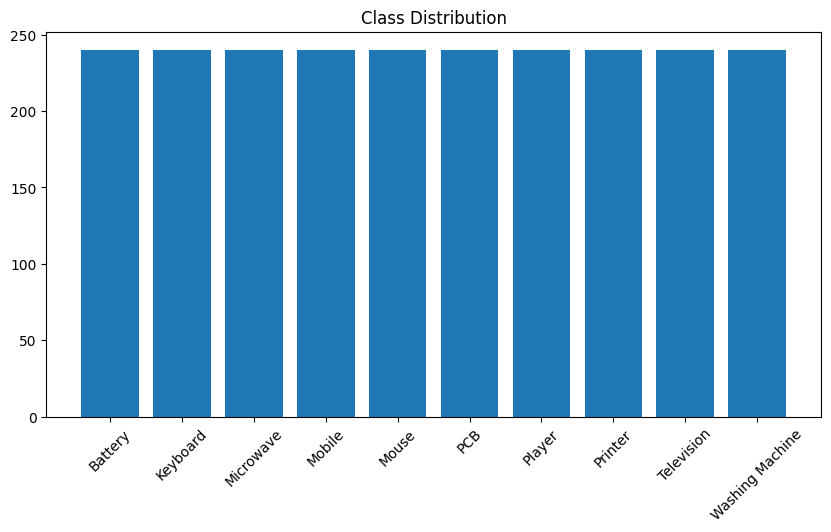

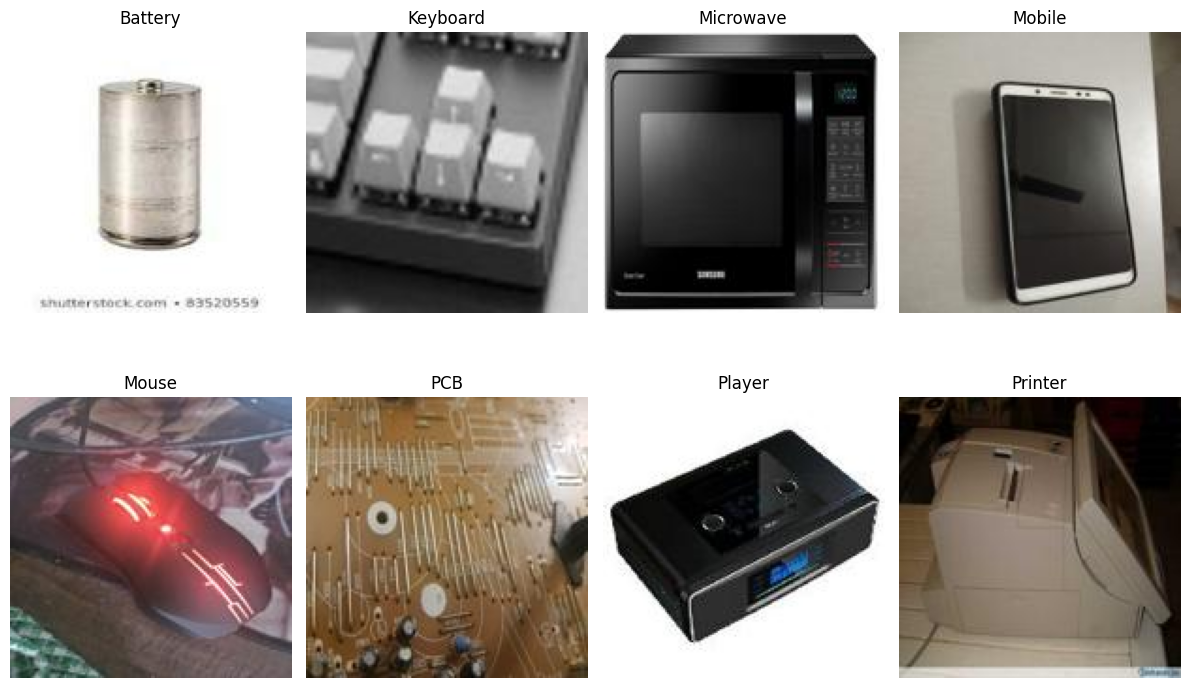


Exploring: /content/modified-dataset/val
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


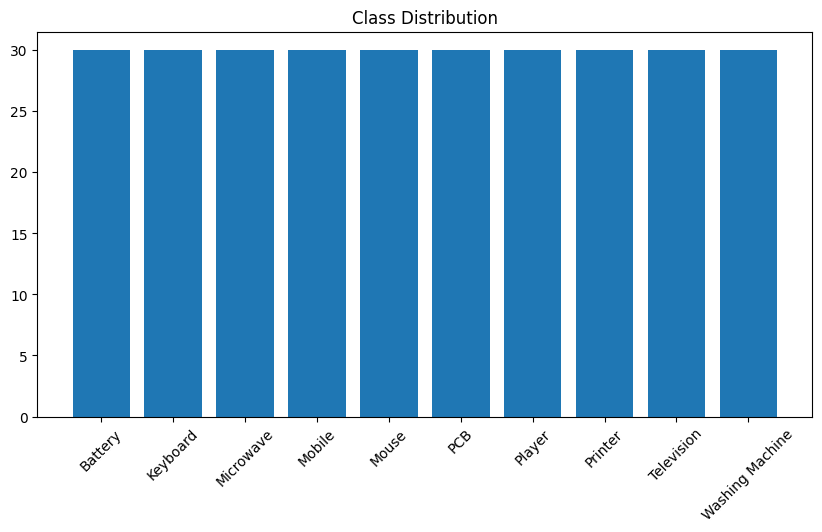

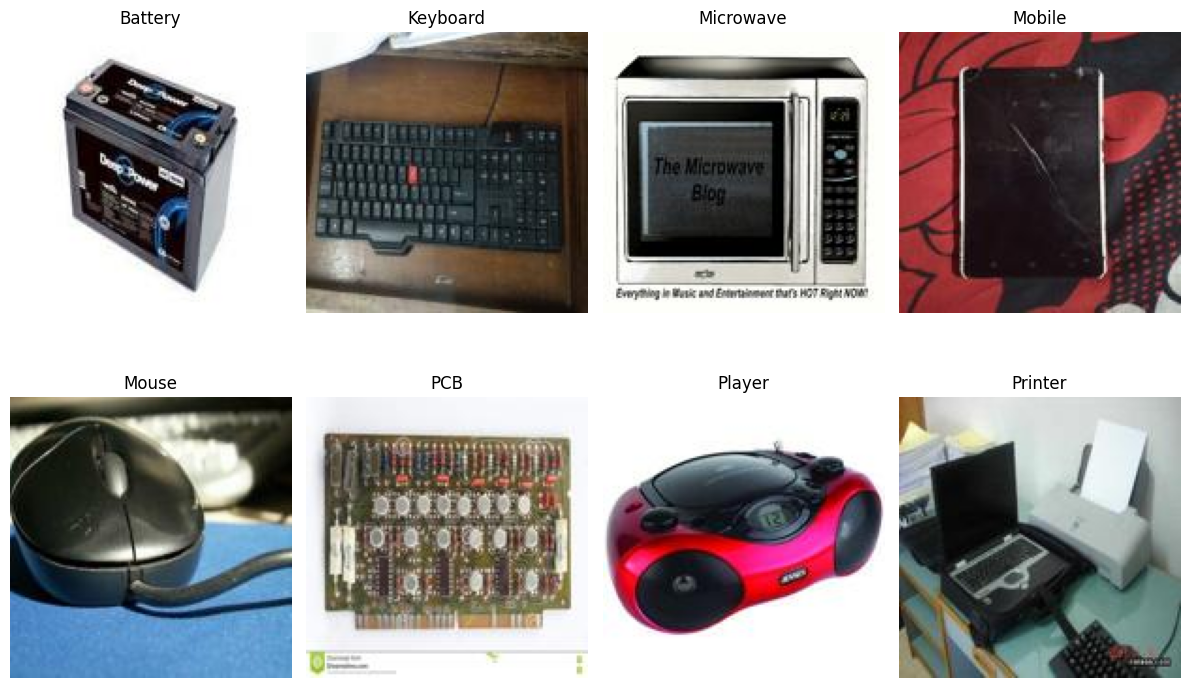


Exploring: /content/modified-dataset/test
Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


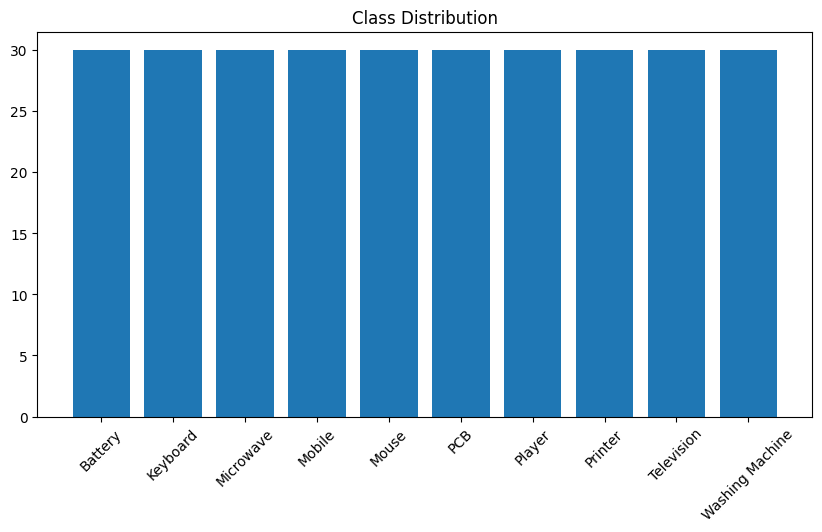

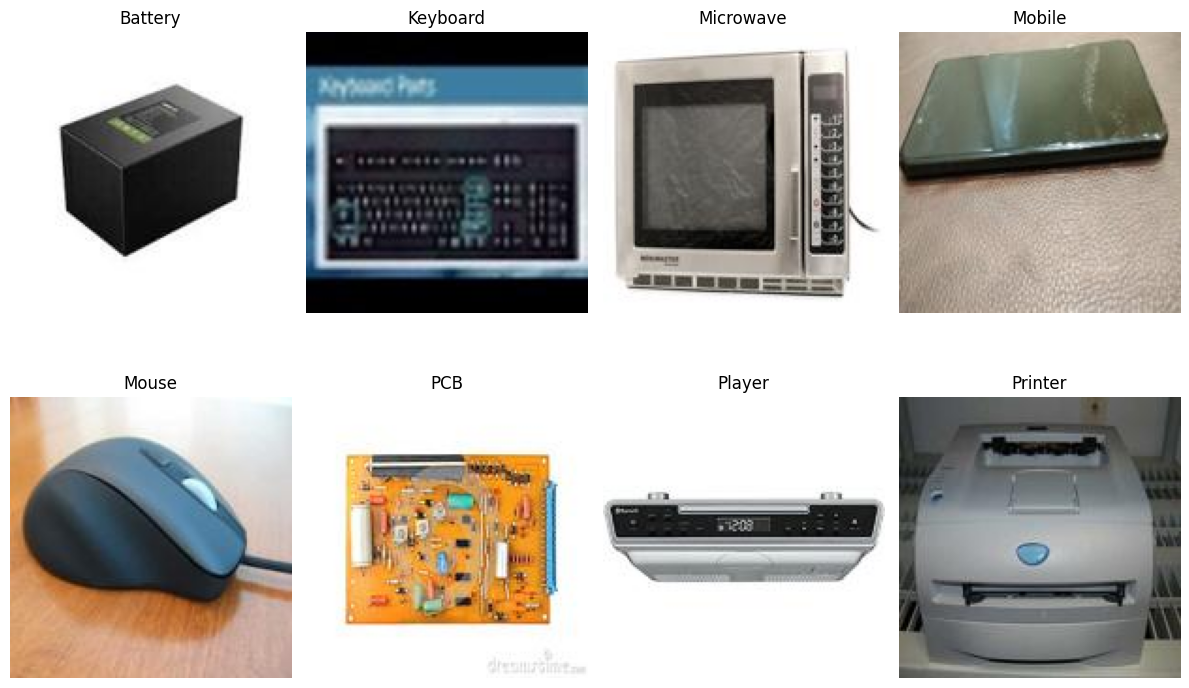

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def explore_dataset(directory):
    """Explore dataset structure and show sample images"""
    print(f"\nExploring: {directory}")
    classes = sorted(os.listdir(directory))
    print(f"Classes: {classes}")

    class_counts = {cls: len(os.listdir(os.path.join(directory, cls))) for cls in classes}

    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 8))
    for i, cls in enumerate(classes[:8]):
        img_path = os.path.join(directory, cls, os.listdir(os.path.join(directory, cls))[0])
        img = Image.open(img_path)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return classes

train_classes = explore_dataset(train_path)
val_classes = explore_dataset(valid_path)
test_classes = explore_dataset(test_path)

In [ ]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    image_size=(128, 128),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=False,
    image_size=(128, 128),
    batch_size=32
)

class_names = train_ds.class_names
print("\nClass names:", class_names)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.

Class names: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


Visualize Batched Data

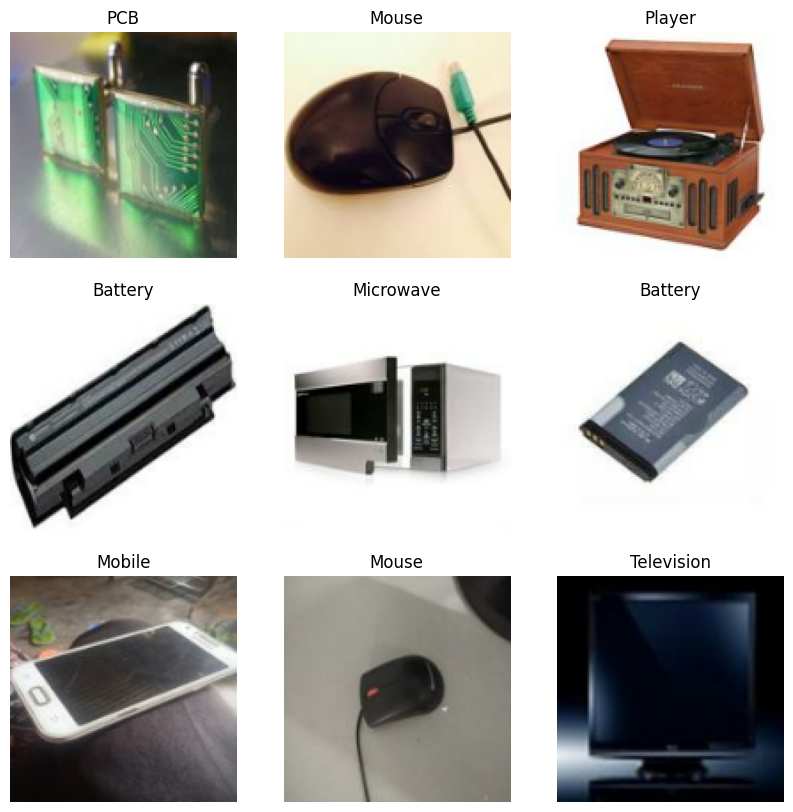

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

Data Augmentation

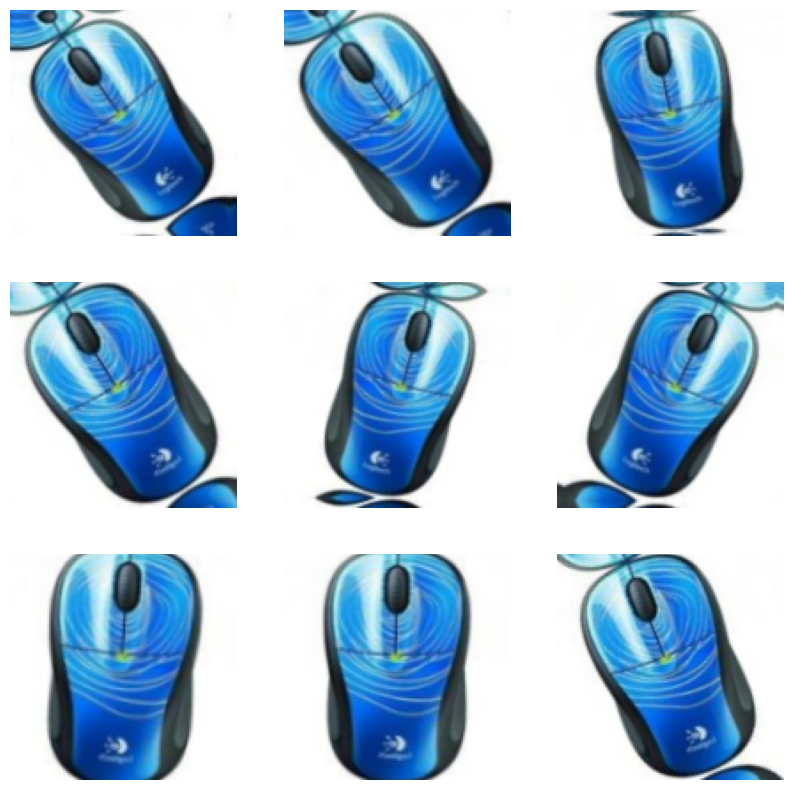

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented = data_augmentation(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetV2B0

base_model = EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze layers

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 976ms/step - accuracy: 0.5025 - loss: 1.6577 - val_accuracy: 0.8967 - val_loss: 0.4950
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8656 - loss: 0.5650 - val_accuracy: 0.9333 - val_loss: 0.3021
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8994 - loss: 0.4011 - val_accuracy: 0.9400 - val_loss: 0.2453
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9028 - loss: 0.3569 - val_accuracy: 0.9500 - val_loss: 0.2131
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 820ms/step - accuracy: 0.9083 - loss: 0.3049 - val_accuracy: 0.9533 - val_loss: 0.1890
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 57s 758ms/step - accuracy: 0.9169 - loss: 0.2842 - val_accuracy: 0.9467 - val_loss: 0.1783
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 749ms/step - accuracy: 0.9190 - loss: 0.2585 - val_accuracy: 0.9500 - val_loss: 0.1639
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 771ms/step - accuracy: 0.9230 - loss: 0.2485 - val_accuracy: 0.9

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop]
)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6954 - loss: 0.8929 - val_accuracy: 0.8700 - val_loss: 0.4655
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7409 - loss: 0.7721 - val_accuracy: 0.8767 - val_loss: 0.4139
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7839 - loss: 0.6573 - val_accuracy: 0.9100 - val_loss: 0.3728
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8154 - loss: 0.5688 - val_accuracy: 0.9167 - val_loss: 0.3505
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8346 - loss: 0.5410 - val_accuracy: 0.9167 - val_loss: 0.3215


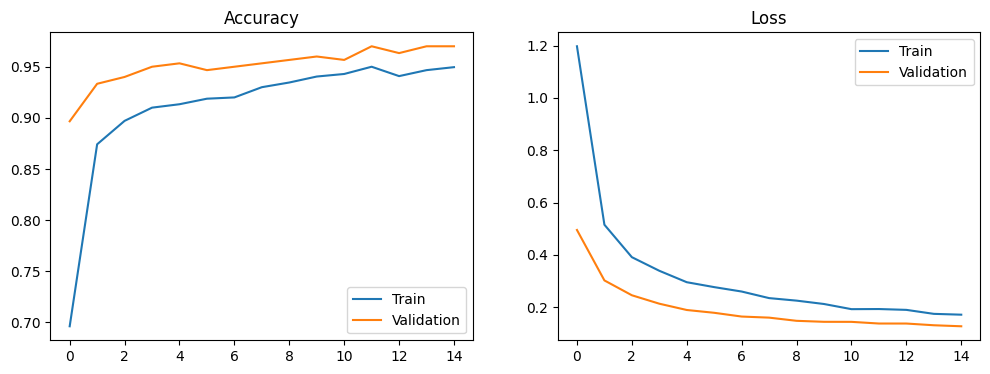

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - accuracy: 0.8701 - loss: 0.3645
Test Accuracy: 89.33%
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 822ms/step
                 precision    recall  f1-score   support

        Battery       0.88      0.73      0.80        30
       Keyboard       0.96      0.90      0.93        30
      Microwave       0.93      0.90      0.92        30
         Mobile       0.94      0.97      0.95        30
          Mouse       0.91      0.97      0.94        30
            PCB       0.76      0.93      0.84        30
         Player       0.79      0.90      0.84        30
        Printer       0.87      0.90      0.89        30
     Television       1.00      0.83      0.91        30
Washing Machine       0.96      0.90      0.93        30

       accuracy                           0.89       300
      macro avg       0.90      0.89      0.89       300
   weighted avg       0.90      0.89      0.89       300



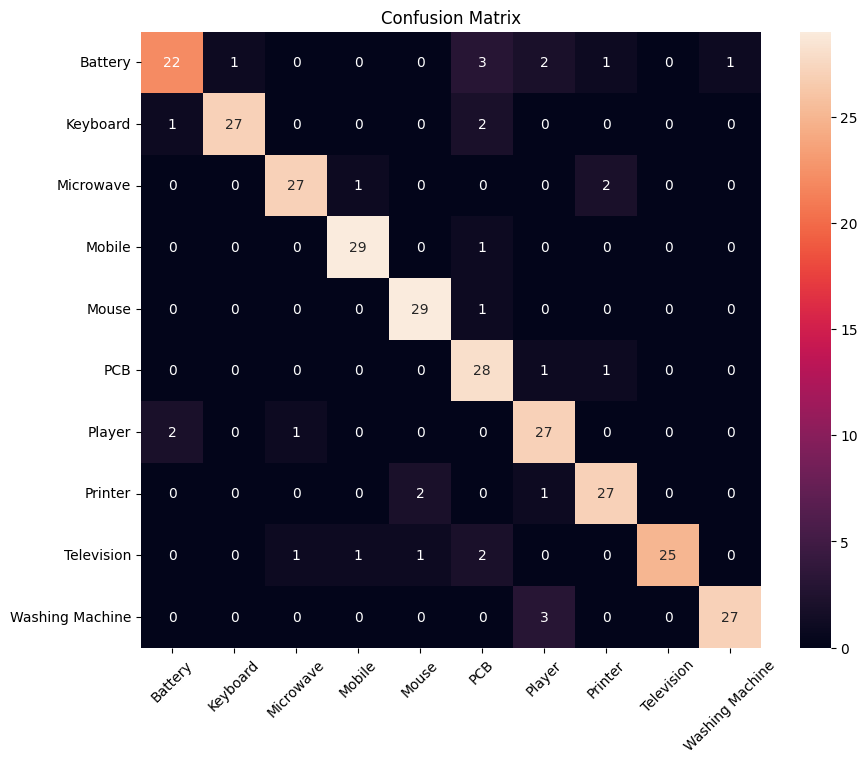

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save('efficientnet_ewaste_model.keras')
print("Model saved!")

Model saved!


In [ ]:
!pip install gradio -q

Model Deployment

Gradio Interface and Preprocessing

In [23]:
import gradio as gr
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

model = tf.keras.models.load_model('efficientnet_ewaste_model.keras')

def classify_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    index = np.argmax(prediction)

    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [22]:
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text"
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e7fa6bd23e541d0651.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
